In [38]:
import numpy as np
import pandas as pd

df = pd.read_csv('495.csv')
df.shape

(494, 3)

In [39]:
df.tail()

,label,id,sequence
489,Inner,Q9P7D8,MCISSSSLLCGINSLKYASNRVGILIPPFQTASSLNIFRPYVIFSR...
490,Inner,P13619,MLSRVVLSAAAAAAPSLKNAALLGPGVLQATRIFHTGQPSLAPVPP...
491,Inner,A0JNC1,MTELRQRVAREPEAPPEDKESESEAKADGETASDSESRVEAVTQPP...
492,Outer,Q9XIA7,MFPGMFMRKPDKAEALKQLRTHVALFGSWVVIIRAAPYVLSYFSDS...
493,Outer,Q5ZIR1,MNIMDFNMKKLAADAGTFLSRAVQFTEEKLGQAEKTELDAHLENLL...


at least 109 instances per class
494 instances before
494 instances after


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


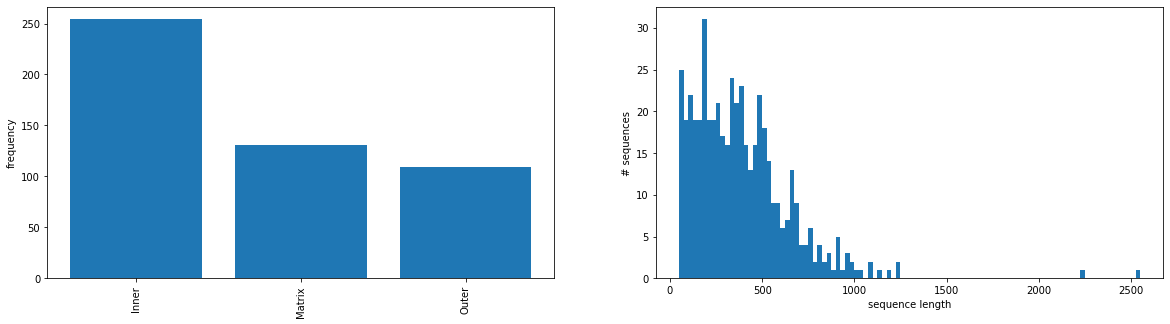

In [64]:
import matplotlib.pyplot as plt
from collections import Counter

# count numbers of instances per class
cnt = Counter(df.label)
# select only 10 most common classes!
top_classes = 3
# sort classes
sorted_classes = cnt.most_common()[:top_classes]
classes = [c[0] for c in sorted_classes]
counts = [c[1] for c in sorted_classes]
print("at least " + str(counts[-1]) + " instances per class")

# apply to dataframe
print(str(df.shape[0]) + " instances before")
df = df[[c in classes for c in df.label]]
print(str(df.shape[0]) + " instances after")

seqs = df.sequence.values
lengths = [len(s) for s in seqs]

# visualize
fig, axarr = plt.subplots(1,2, figsize=(20,5))
axarr[0].bar(range(len(classes)), counts)
plt.sca(axarr[0])
plt.xticks(range(len(classes)), classes, rotation='vertical')
axarr[0].set_ylabel('frequency')

axarr[1].hist(lengths, bins=100, normed=False)
axarr[1].set_xlabel('sequence length')
axarr[1].set_ylabel('# sequences')
plt.show()

In [65]:
from sklearn.preprocessing import LabelBinarizer

# Transform labels to one-hot
lb = LabelBinarizer()
Y = lb.fit_transform(df.label)

In [66]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# maximum length of sequence, everything afterwards is discarded!
max_length = 800

#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(seqs)
X = sequence.pad_sequences(X, maxlen=max_length)

Shape of X before SMOTE: (494, 800)
Shape of X after SMOTE: (762, 800)


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


<BarContainer object of 3 artists>

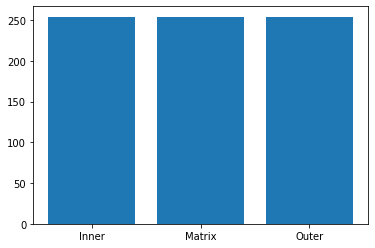

In [82]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, Y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')
a = []
for i in range(len(y_sm)):
    if y_sm[i][0] == 1:
        a.append("Inner") 
    elif y_sm[i][1] == 1:
        a.append("Matrix")
    else:
        a.append("Outer")  
plt.bar(x = ['Inner', 'Matrix', 'Outer'], height = [a.count('Inner'), a.count('Matrix'), a.count('Outer')])

In [87]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

embedding_dim = 20

# create the model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(top_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 800, 20)           420       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 800, 64)           3904      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 400, 64)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 400, 32)           6176      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 200, 32)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 200, 16)           1552      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 100, 16)          

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=.2)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16)

Train on 609 samples, validate on 153 samples
Epoch 1/10
609/609 [==============================] - 2s 3ms/step - loss: 1.0801 - accuracy: 0.4007 - val_loss: 1.0748 - val_accuracy: 0.3464
Epoch 2/10
609/609 [==============================] - 1s 2ms/step - loss: 1.0209 - accuracy: 0.4745 - val_loss: 1.0121 - val_accuracy: 0.4837
Epoch 3/10
609/609 [==============================] - 1s 2ms/step - loss: 0.9377 - accuracy: 0.5353 - val_loss: 0.9355 - val_accuracy: 0.5686
Epoch 4/10
609/609 [==============================] - 1s 2ms/step - loss: 0.8841 - accuracy: 0.5813 - val_loss: 0.9421 - val_accuracy: 0.5686
Epoch 5/10
609/609 [==============================] - 1s 2ms/step - loss: 0.7924 - accuracy: 0.6519 - val_loss: 0.9565 - val_accuracy: 0.5621
Epoch 6/10
609/609 [==============================] - 1s 2ms/step - loss: 0.6894 - accuracy: 0.6962 - val_loss: 0.8758 - val_accuracy: 0.5882
Epoch 7/10
609/609 [==============================] - 1s 2ms/step - loss: 0.6215 - accuracy: 0.7323 - 

train-acc = 0.9146141215106732
test-acc = 0.6209150326797386


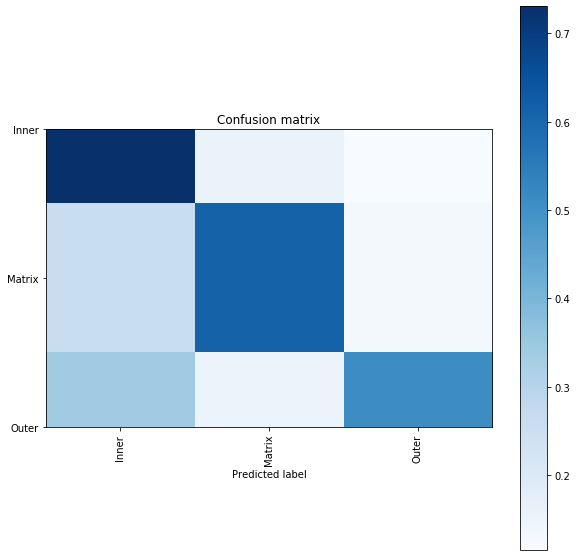

              precision    recall  f1-score   support

       Inner       0.56      0.73      0.63        52
      Matrix       0.69      0.61      0.65        54
       Outer       0.65      0.51      0.57        47

    accuracy                           0.62       153
   macro avg       0.63      0.62      0.62       153
weighted avg       0.63      0.62      0.62       153



In [85]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.xlabel('Predicted label')
plt.show()

print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

In [86]:
model.save('model495.h5')